In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline

import tensorflow as tf
from tensorflow.contrib.integrate import odeint, odeint_fixed

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import tensorflow as tf
import numpy as np
import glob
from functools import partial

_FILES_SHUFFLE = 1024
_SHUFFLE_FACTOR = 4


def parse_tfrecord_tf(record, res, rnd_crop):
    features = tf.parse_single_example(record, features={
        'shape': tf.FixedLenFeature([3], tf.int64),
        'data': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([1], tf.int64)})
    # label is always 0 if uncondtional
    # to get CelebA attr, add 'attr': tf.FixedLenFeature([40], tf.int64)
    data, label, shape = features['data'], features['label'], features['shape']
    label = tf.cast(tf.reshape(label, shape=[]), dtype=tf.int32)
    img = tf.cast(tf.decode_raw(data, tf.uint8), tf.float32) / 256.
    if rnd_crop:
        # For LSUN Realnvp only - random crop
        img = tf.reshape(img, shape)
        img = tf.random_crop(img, [res, res, 3])
    img = tf.reshape(img, [res, res, 3])
    img = tf.image.random_jpeg_quality(img, 70,100)
    img = tf.clip_by_value(img + 0.01*tf.random_normal(shape=[res,res,3]),0,1)
    
    return img, label  # to get CelebA attr, also return attr


def input_fn(tfr_file, shards, rank, pmap, fmap, n_batch, resolution, rnd_crop, is_training):
    files = tf.data.Dataset.list_files(tfr_file)
    if ('lsun' not in tfr_file) or is_training:
        # For 'lsun' validation, only one shard and each machine goes over the full dataset
        # each worker works on a subset of the data
        files = files.shard(shards, rank)
    if is_training:
        # shuffle order of files in shard
        files = files.shuffle(buffer_size=_FILES_SHUFFLE)
    dset = files.apply(tf.contrib.data.parallel_interleave(
        tf.data.TFRecordDataset, cycle_length=fmap))
    if is_training:
        dset = dset.shuffle(buffer_size=n_batch * _SHUFFLE_FACTOR)
    dset = dset.repeat()
    dset = dset.map(lambda x: parse_tfrecord_tf(
        x, resolution, rnd_crop), num_parallel_calls=pmap)
    dset = dset.batch(n_batch)
    dset = dset.map(lambda x,y:(tf.image.random_flip_left_right(tf.image.random_crop(tf.image.resize_nearest_neighbor( x, size=[70,70]), [n_batch,64,64,3])), y), num_parallel_calls=pmap)
    dset = dset.prefetch(16)
    itr = dset.make_one_shot_iterator()
    return itr.get_next()


def get_tfr_file(data_dir, split, res_lg2):
    data_dir = os.path.join(data_dir, split)
    tfr_prefix = os.path.join(data_dir, os.path.basename(data_dir))
    tfr_file = tfr_prefix + '-r%02d-s-*-of-*.tfrecords' % (res_lg2)
    files = glob.glob(tfr_file)
    assert len(files) == int(files[0].split(
        "-")[-1].split(".")[0]), "Not all tfrecords files present at %s" % tfr_prefix
    return tfr_file


def get_data(data_dir, shards, rank, pmap, fmap, n_batch_train, n_batch_test, n_batch_init, resolution, rnd_crop):
    assert resolution == 2 ** int(np.log2(resolution))

    train_file = get_tfr_file(data_dir, 'train', int(np.log2(resolution)))
    valid_file = get_tfr_file(data_dir, 'validation', int(np.log2(resolution)))

    train_itr = input_fn(train_file, shards, rank, pmap,
                         fmap, n_batch_train, resolution, rnd_crop, True)
    valid_itr = input_fn(valid_file, shards, rank, pmap,
                         fmap, n_batch_test, resolution, rnd_crop, False)

    return train_itr, valid_itr

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
from functools import partial

In [5]:
from tensorflow.python.framework import constant_op
class Squeeze2d(tfb.Reshape):
    """
    Borrowed from https://github.com/openai/glow/blob/master/tfops.py
    """
    
    def __init__(self,
                 event_shape_in,
                 factor=2,
                 is_constant_jacobian=True,
                 validate_args=False,
                 name=None):

        assert factor >= 1
        name = name or "squeeze"
        self.factor = factor
        event_shape_out = 1*event_shape_in
        event_shape_out[0] //=2
        event_shape_out[1] //=2
        event_shape_out[2] *=4
        
        super(Squeeze2d, self).__init__(
            event_shape_out=event_shape_out,
            event_shape_in=event_shape_in,
        validate_args=validate_args,
        name=name)
        
    
    def _forward(self, x):
        
        if self.factor == 1:
            return x
        shape = x.get_shape()
        height = int(shape[1])
        width = int(shape[2])
        n_channels = int(shape[3])
        assert height % self.factor == 0 and width % self.factor == 0
        x = tf.reshape(x, [-1, height//self.factor, self.factor,
                           width//self.factor, self.factor, n_channels])
        x = tf.transpose(x, [0, 1, 3, 4, 2, 5])
        x = tf.reshape(x, [-1, height//self.factor, width //
                           self.factor, n_channels*self.factor*self.factor])
        return x

    def _inverse(self, x):
        if self.factor == 1:
            return x
        shape = x.get_shape()
        height = int(shape[1])
        width = int(shape[2])
        n_channels = int(shape[3])
        assert n_channels >= 4 and n_channels % 4 == 0
        x = tf.reshape(
            x, (-1, height, width, self.factor, self.factor, int(n_channels/self.factor**2)))
        x = tf.transpose(x, [0, 1, 4, 2, 3, 5])
        x = tf.reshape(x, (-1, int(height*self.factor),
                           int(width*self.factor), int(n_channels/self.factor**2)))
        return x

In [6]:
# Define the flow
def func(y, t, name):
    shape = y.shape
    with tf.variable_scope('network_%s'%name, reuse=tf.AUTO_REUSE):
        y = tf.layers.conv2d(y, shape[-1]//2 +1, 5,activation=tf.nn.leaky_relu,padding='same')
        y = tf.layers.conv2d(y, shape[-1], 5, activation=tf.nn.leaky_relu,padding='same')
    return y

def inv_func(y,t,name):
    return -func(y,t,name)

In [7]:
class ODENet(tfb.Bijector):

    def __init__(self,
       h=1.0,
       dt=0.01,
       is_constant_jacobian=True,
       validate_args=False,
       name=None):
        self.h = h
        self.dt = dt
        name = name or "revnet"
        super(ODENet, self).__init__(
        forward_min_event_ndims=3,
        is_constant_jacobian=is_constant_jacobian,
        validate_args=validate_args,
        name=name)
        
    def _forward(self, x):
        net = odeint_fixed(partial(func, name=self.name), x, array([0, self.h]).astype('float32'), dt=self.dt)[-1]
        return net
    
    def _inverse(self, x):
        net = odeint_fixed(partial(inv_func, name=self.name), x, array([0, self.h]).astype('float32'), dt=self.dt)[-1]
        return net

    def _inverse_log_det_jacobian(self, y):
        return constant_op.constant(0., x.dtype.base_dtype)

    def _forward_log_det_jacobian(self, x):       
        return constant_op.constant(0., x.dtype.base_dtype)

In [8]:
tf.reset_default_graph()
batch_size = 32

titr, vitr = get_data('/data2/celeba/celeba-tfr/', 1, 0, pmap=16, fmap=1, n_batch_train=batch_size, n_batch_init=256, n_batch_test=50,
         resolution=256, rnd_crop=False)

lr = tf.placeholder_with_default(0.001,shape=[])
x = titr[0]#tf.placeholder(shape=[batch_size, 32,32, 1],dtype=tf.float32)
dt = tf.cast(tf.placeholder_with_default(0.01,shape=[]), dtype=tf.float64)

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.


/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/lib/python3.7/site-packages/tensorflow/python/util/

In [9]:
c1 = [ODENet(name='layer1', h=0.25),
      ODENet(name='layer1b', h=0.25),
      Squeeze2d(event_shape_in=[32,32,4*3])]

c2 = [ODENet(name='layer2', h=0.25),
      ODENet(name='layer2b', h=0.25),
      Squeeze2d(event_shape_in=[16,16,16*3])]

chain1 = tfb.Chain(c1)
chain2 = tfb.Chain(c2)

In [10]:
16*3

48

In [11]:
rep1 = chain1.forward(x)
rep = chain2.forward(rep1)

In [12]:
rec1 = chain2.inverse(1.*rep+0.)
rec = chain1.inverse(rec1)

In [13]:
mask1 = np.ones((batch_size, 32, 32, 12))
mask1 = mask1.reshape((batch_size,32,32, 2, 2, 3))
mask1[:,:,:,1,:,:] = 0
mask1[:,:,:,:,0,:] = 0
mask1 = mask1.reshape((batch_size,32,32,12))
inv_mask1 = 1. -mask1

mask2 = np.ones((batch_size, 16, 16, 48))
mask2 = mask2.reshape((batch_size,16, 16, 4, 4, 3))
mask2[:,:,:,:,2:,:] = 0
mask2 = mask2.reshape((batch_size,16,16,48))
inv_mask2 = 1. - mask2

projection = chain1.inverse(chain2.inverse(rep*mask2))

In [14]:
projection

<tf.Tensor 'chain_of_layer1_of_layer1b_of_squeeze_2/inverse/squeeze/inverse/Reshape_1:0' shape=(32, 64, 64, 3) dtype=float32>

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
xi, yo,r,p = sess.run([x,rep,rec,projection])

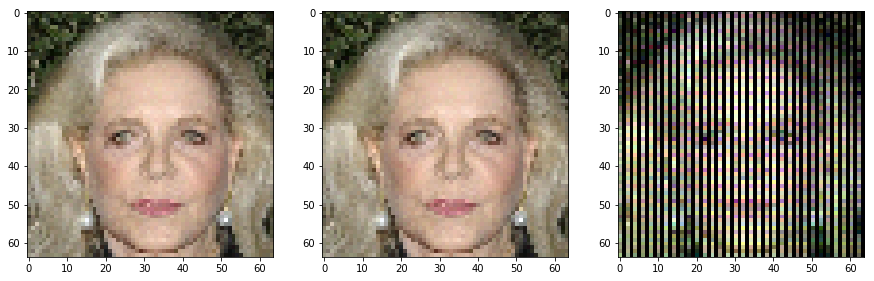

In [17]:
figure(figsize=(15,5))
subplot(131)
imshow(xi[0,:,:])
subplot(132)
imshow(clip(r[0,:,:],0,1))
subplot(133)
imshow(clip(p[0,:,:],0,1))

In [18]:
loss = tf.reduce_mean(tf.reduce_sum((rep1*inv_mask1)**2,axis=[1,2,3])) + tf.reduce_mean(tf.reduce_sum((rep*inv_mask2)**2,axis=[1,2,3])) + tf.reduce_mean(tf.reduce_sum((projection - x)**2,axis=[1,2,3]))

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

In [20]:
opt_op = optimizer.minimize(loss)

In [21]:
sess.run(tf.global_variables_initializer())

In [22]:
c,p,t = sess.run([rep,projection,x],feed_dict={lr:0.001})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


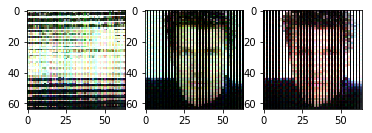

In [23]:
subplot(131)
imshow(c[0].reshape((64,64,3)))
subplot(132)
imshow(p[0].reshape((64,64,3)))
subplot(133)
imshow((t[0] -p[0]).reshape((64,64,3)));

In [24]:
losses = []
losses_samp = []

In [25]:
nepochs=500
for ep in range(nepochs):
    _, l, c,r  = sess.run([opt_op, loss,rep,rec],
                            feed_dict={lr:0.001})
    losses.append(l)
    if ep % 10 == 0:
        print(l)

8041.7466
3719.6997
2189.3955
1211.0585
789.15576
674.8147
674.47314
554.0671
560.5086
509.76877
440.80835
507.4936
413.48114
392.33905
417.39178
399.32495
387.6945
434.21667
381.53546
387.7133
323.10663
321.50494
350.56506
644.95685
477.14417
418.42896
428.67896
418.53888
360.2228
324.32886
354.0752
336.2815
324.26544
315.607
318.03406
288.7567
306.8132
272.96838
295.51184
253.19995
253.11479
310.3423
260.98254
273.21442
259.92993
248.10095
233.33469
277.53058
235.84198
231.72299


In [29]:
nepochs=1000
for ep in range(nepochs):
    _, l, c,r  = sess.run([opt_op, loss,rep,rec],
                            feed_dict={lr:0.0002})
    losses.append(l)
    if ep % 10 == 0:
        print(l)

217.38293
231.7117
199.99615
202.57283
209.32059
207.33041
199.38895
165.97842
205.50652
188.13211
184.56467
169.73616
175.65916
195.4079
181.11072
182.78366
185.0763
172.38885
178.49522
198.73114
182.00755
170.05766
173.08365
176.55798
194.6727
151.89278
162.50894
157.47415


KeyboardInterrupt: 

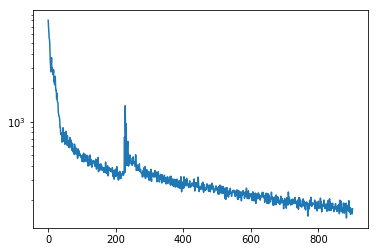

In [30]:
plot(losses)
yscale('log')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


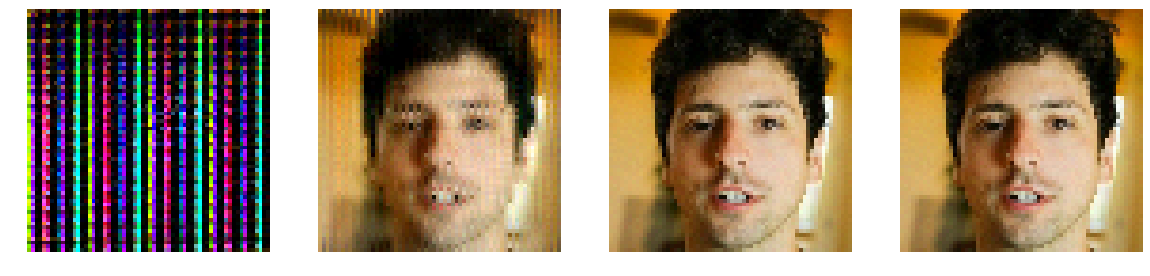

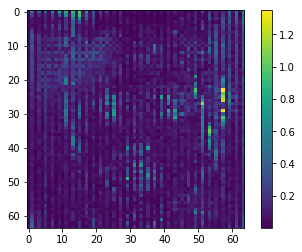

In [31]:
c,r,t,p = sess.run([rep,rec,x,projection],feed_dict={ lr:0.001})
figure(figsize=(20,5))
subplot(141)
imshow(c[0].reshape((64,64,3)));
axis('off')
subplot(142)
imshow(p[0],vmin=0,vmax=1,cmap='gray')
axis('off')
subplot(143)
imshow(t[0])
axis('off')
subplot(144)
imshow(r[0])
axis('off')

figure()

imshow(sum(abs(t[0] - p[0]),axis=-1));colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


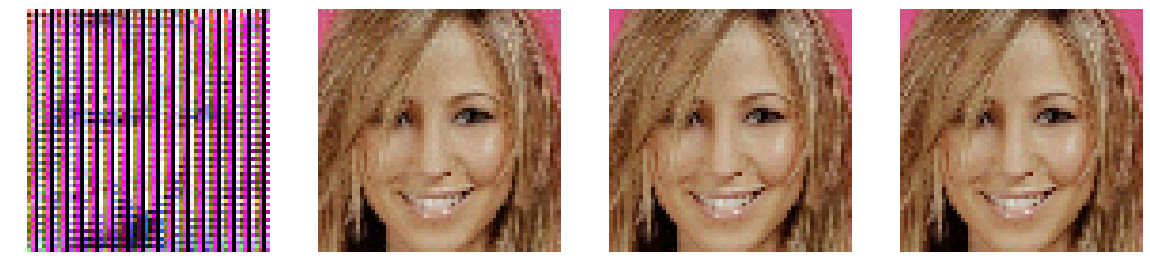

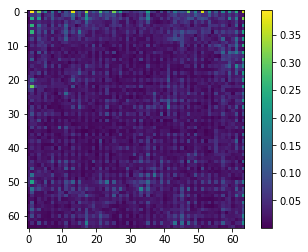

In [132]:
c,r,t,p = sess.run([rep,rec,x,projection],feed_dict={ lr:0.001})
figure(figsize=(20,5))
subplot(141)
imshow(c[0].reshape((64,64,3)));
axis('off')
subplot(142)
imshow(p[0],vmin=0,vmax=1,cmap='gray')
axis('off')
subplot(143)
imshow(t[0])
axis('off')
subplot(144)
imshow(r[0])
axis('off')

figure()

imshow(sum(abs(t[0] - p[0]),axis=-1));colorbar()

In [72]:
tf.trainable_variables()


[<tf.Variable 'network_layer1d/conv2d/kernel:0' shape=(5, 5, 12, 7) dtype=float32_ref>,
 <tf.Variable 'network_layer1d/conv2d/bias:0' shape=(7,) dtype=float32_ref>,
 <tf.Variable 'network_layer1d/conv2d_1/kernel:0' shape=(5, 5, 7, 12) dtype=float32_ref>,
 <tf.Variable 'network_layer1d/conv2d_1/bias:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'network_layer1c/conv2d/kernel:0' shape=(5, 5, 12, 7) dtype=float32_ref>,
 <tf.Variable 'network_layer1c/conv2d/bias:0' shape=(7,) dtype=float32_ref>,
 <tf.Variable 'network_layer1c/conv2d_1/kernel:0' shape=(5, 5, 7, 12) dtype=float32_ref>,
 <tf.Variable 'network_layer1c/conv2d_1/bias:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'network_layer1b/conv2d/kernel:0' shape=(5, 5, 12, 7) dtype=float32_ref>,
 <tf.Variable 'network_layer1b/conv2d/bias:0' shape=(7,) dtype=float32_ref>,
 <tf.Variable 'network_layer1b/conv2d_1/kernel:0' shape=(5, 5, 7, 12) dtype=float32_ref>,
 <tf.Variable 'network_layer1b/conv2d_1/bias:0' shape=(12,) dtype=float32_r

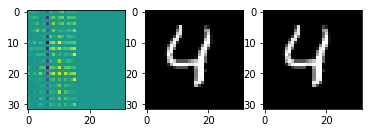

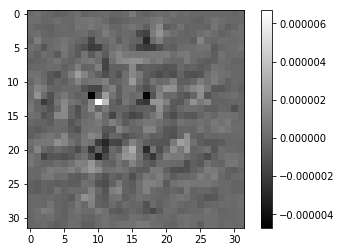

In [167]:
inds = choice(len(x_test),batch_size)
labels = targets_test[inds]
c,r,t = sess.run([rep,rec,x],feed_dict={x: x_test[inds], lr:0.001})
subplot(131)
imshow(c[0].reshape((32,32)));
subplot(132)
imshow(r[0].reshape((32,32)),vmin=0,vmax=1,cmap='gray')
subplot(133)
imshow(t[0].reshape((32,32)),cmap='gray');

figure()

imshow(r[0].reshape((32,32)) - t[0].reshape((32,32)), cmap='gray');colorbar()

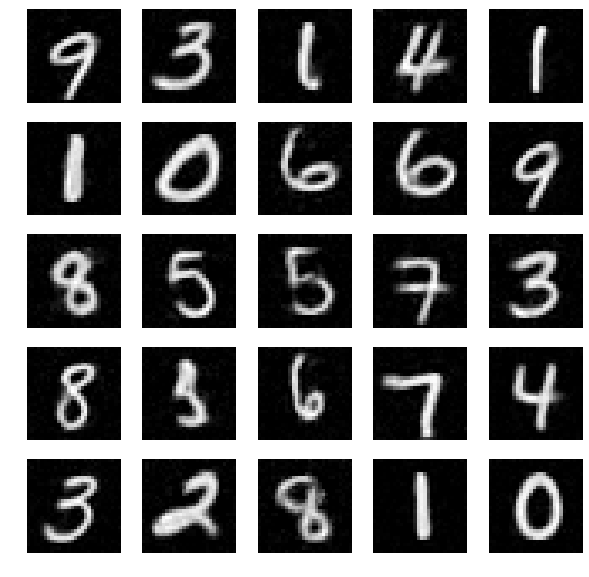

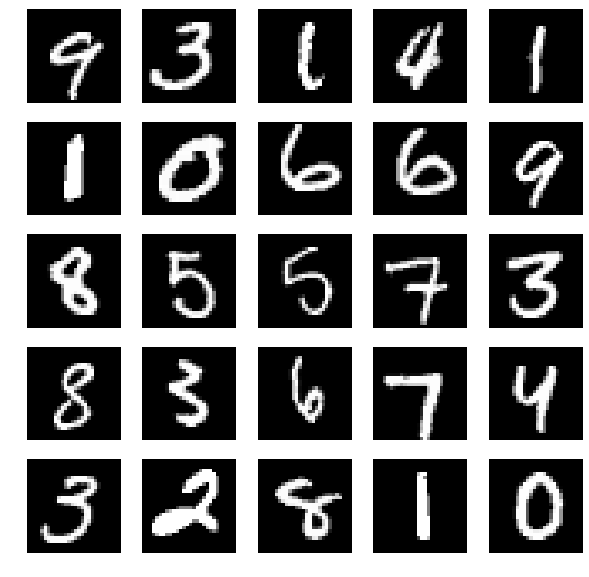

In [257]:
figure(figsize=(10,10))
for i in range(25):
    subplot(5,5,i+1)
    imshow(r[i].reshape(28,28),cmap='gray',vmin=0)
    axis('off')

figure(figsize=(10,10))
for i in range(25):
    subplot(5,5,i+1)
    imshow(t[i].reshape(28,28),cmap='gray')
    axis('off')

(-1, 1)

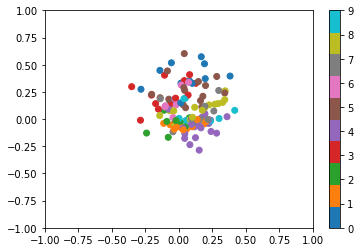

In [181]:
scatter(c[:,0],c[:,1],c=labels, cmap='tab10'); colorbar();
xlim(-1,1)
ylim(-1,1)

(-0.1, 0.1)

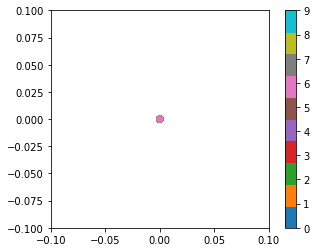

In [182]:
scatter(c[:,-1],c[:,-2],c=labels, cmap='tab10'); colorbar(); gca().set_aspect('equal')
xlim(-0.1,0.1)
ylim(-0.1,0.1)

In [47]:
c[:,-1]

array([-0., -0.,  0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,
       -0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
       -0., -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0.,
       -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0.,
       -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0.,
        0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,
       -0., -0., -0., -0., -0., -0., -0.,  0., -0.,  0.,  0.],
      dtype=float32)

In [234]:
tf.trainable_variables()

[<tf.Variable 'network_0/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'network_0/dense/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'network_0/dense_1/kernel:0' shape=(512, 784) dtype=float32_ref>,
 <tf.Variable 'network_0/dense_1/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'network_1/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'network_1/dense/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'network_1/dense_1/kernel:0' shape=(512, 784) dtype=float32_ref>,
 <tf.Variable 'network_1/dense_1/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'network_2/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'network_2/dense/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'network_2/dense_1/kernel:0' shape=(512, 784) dtype=float32_ref>,
 <tf.Variable 'network_2/dense_1/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'network_3/dense/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Varia